# Top overlapping annotations by weighted sum for ecoli cohort

In [1]:
import pandas as pd


pd.set_option("display.max_columns", None) # show all cols
pd.set_option('display.max_colwidth', None) # show full width of showing cols
pd.set_option("display.expand_frame_repr", False) # print cols side by side as it's supposed to be

## Read token information from bed files

In [2]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'SAUR')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,0,6,TTTTCTT,0.000064,ALF22G140
1,1,7,9,ACC,-0.000395,ALF22G140
2,1,10,13,GACA,0.001573,ALF22G140
3,1,14,18,AGAAT,-0.000986,ALF22G140
4,1,19,25,TAATTAT,0.000795,ALF22G140
...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044
176721939,5,181674,181676,GCA,-0.003468,AH21C044
176721940,5,181677,181680,TCCA,-0.000228,AH21C044


In [3]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,0,6,TTTTCTT,0.000064,ALF22G140,7
1,1,7,9,ACC,-0.000395,ALF22G140,3
2,1,10,13,GACA,0.001573,ALF22G140,4
3,1,14,18,AGAAT,-0.000986,ALF22G140,5
4,1,19,25,TAATTAT,0.000795,ALF22G140,7
...,...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044,3
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044,6
176721939,5,181674,181676,GCA,-0.003468,AH21C044,3
176721940,5,181677,181680,TCCA,-0.000228,AH21C044,4


In [4]:
len(bedDf.tokens.unique())

3894

In [5]:
highscoreCutoff = bedDf.score.mean() + 3 * bedDf.score.std()
highscoreCutoff

np.float64(0.012133979502852287)

In [6]:
highscoreDf = bedDf[bedDf.score > highscoreCutoff]
highscoreDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
13703,1,75447,75454,TATACTTT,0.013623,ALF22G140,8
13723,1,75557,75561,AATGA,0.014487,ALF22G140,5
13725,1,75567,75572,CCTGAG,0.015546,ALF22G140,6
13753,1,75724,75731,CTGCACCC,0.018303,ALF22G140,8
13785,1,75898,75902,GAGCA,0.018827,ALF22G140,5
...,...,...,...,...,...,...,...
176698433,5,50635,50641,AATGTTT,0.016897,AH21C044,7
176698449,5,50725,50728,ACTG,0.020198,AH21C044,4
176698513,5,51074,51079,GGCGCG,0.015019,AH21C044,6
176698639,5,51802,51807,AAATAT,0.013009,AH21C044,6


In [7]:
len(highscoreDf.tokens.unique())

1991

In [8]:
highscoreDf.shape

(286987, 7)

In [9]:
highscoreDf.token_length.value_counts()

token_length
6     104579
5      75597
7      51246
4      33151
8      16706
3       2680
9       1348
10       798
2        738
13        73
1         68
11         3
Name: count, dtype: int64

<Axes: xlabel='token_length', ylabel='Count'>

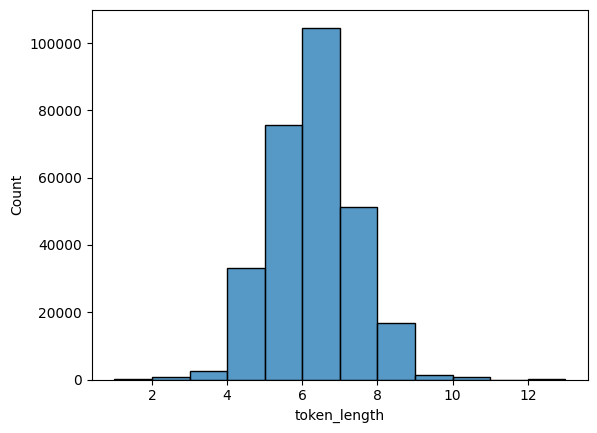

In [10]:
import seaborn as sns

sns.histplot(highscoreDf.token_length, binwidth=1)

## Read bed files containing overlapping tokens and attribution scores

In [11]:
from tqdm import tqdm

import os
import pandas as pd
from pathlib import Path


overlappingFilesDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'overlapping_with_annotations', 'SAUR')

overlappingDfList = []
for overlappingFile in tqdm(os.listdir(overlappingFilesDir)):
    df = pd.read_csv(Path(overlappingFilesDir, overlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
    df = df[df.feature_type.isin(['CDS', 'ncRNA', 'oriC', 'regulatory_region', 'oriT'])]
    df['tube_code'] = [overlappingFile.split('_')[0]]*df.shape[0]
    df = df[df.tokens.apply(lambda x: (len(x) >= 5))].reset_index()
    df['gene'] = df.gene.str.lower()
    overlappingDfList.append(df)
overlappingDf = pd.concat(overlappingDfList, ignore_index=True)
overlappingDf = overlappingDf.drop_duplicates()
overlappingDf

 13%|█▎        | 66/515 [01:43<11:13,  1.50s/it]/tmp/ipykernel_28605/1008075940.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(overlappingFilesDir, overlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
 24%|██▎       | 122/515 [03:13<09:12,  1.41s/it]/tmp/ipykernel_28605/1008075940.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(overlappingFilesDir, overlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
 33%|███▎      | 172/515 [04:35<08:52,  1.55s/it]/tmp/ipykernel_28605/1008075940.py:12: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(overlappingFilesD

,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
0,3,1,138,145,AAAGTAAA,0.009005,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
1,4,1,146,151,AGATAT,-0.010377,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
2,6,1,156,160,GTTGA,-0.016608,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
3,8,1,164,169,TTTAGG,-0.011910,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
4,9,1,170,175,TGTAGA,0.002626,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
...,...,...,...,...,...,...,...,...,...,...,...,...
110816017,337313,5,205763,205769,ATGATAT,0.002546,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRef50_A0A0D1JKS9,UniRef:UniRef90_A0A0D1JKS9;gene=pulO",AH21K020
110816018,337314,5,205770,205775,CCATCA,0.000022,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRef50_A0A0D1JKS9,UniRef:UniRef90_A0A0D1JKS9;gene=pulO",AH21K020
110816019,337315,5,205776,205781,ATTTTT,-0.002056,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRef50_A0A0D1JKS9,UniRef:UniRef90_A0A0D1JKS9;gene=pulO",AH21K020
110816020,337316,5,205782,205787,AGGAGG,0.000008,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulo,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:U

## Get overlapping tokens for high-score tokens

In [12]:
highscoreTokenOverlapsDf = overlappingDf.merge(
    highscoreDf[['contig_id', 'start_position', 'end_position', 'tokens']],
    on=['contig_id', 'start_position', 'end_position', 'tokens'],
    how='inner',
)
highscoreTokenOverlapsDf

,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
0,17,1,212,217,TGATTT,0.016428,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
1,34,1,302,309,AAAAATCA,0.012217,CDS,OILJNO_00005,acyl carrier protein,acpp,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
2,43,1,483,491,AAAGAAAAG,0.018888,CDS,OILJNO_00010,ribonuclease III,rnc,"ID=OILJNO_00010;Name=ribonuclease III;locus_tag=OILJNO_00010;product=ribonuclease III;Dbxref=COG:COG0571,COG:K,EC:3.1.26.3,GO:0004525,GO:0005737,GO:0006364,GO:0006397,GO:0008033,GO:0019843,GO:0046872,RefSeq:WP_000043237.1,SO:0001217,UniParc:UPI0000054AFA,UniRef:UniRef100_A6U152,UniRef:UniRef50_Q4L5T5,UniRef:UniRef90_A6U152;gene=rnc",AH20I016
3,64,1,604,608,AATGA,0.015653,CDS,OILJNO_00010,ribonuclease III,rnc,"ID=OILJNO_00010;Name=ribonuclease III;locus_tag=OILJNO_00010;product=ribonuclease III;Dbxref=COG:COG0571,COG:K,EC:3.1.26.3,GO:0004525,GO:0005737,GO:0006364,GO:0006397,GO:0008033,GO:0019843,GO:0046872,RefSeq:WP_000043237.1,SO:0001217,UniParc:UPI0000054AFA,UniRef:UniRef100_A6U152,UniRef:UniRef50_Q4L5T5,UniRef:UniRef90_A6U152;gene=rnc",AH20I016
4,65,1,609,615,TTTTAAT,0.018532,CDS,OILJNO_00010,ribonuclease III,rnc,"ID=OILJNO_00010;Name=ribonuclease III;locus_tag=OILJNO_00010;product=ribonuclease III;Dbxref=COG:COG0571,COG:K,EC:3.1.26.3,GO:0004525,GO:0005737,GO:0006364,GO:0006397,GO:0008033,GO:0019843,GO:0046872,RefSeq:WP_000043237.1,SO:0001217,UniParc:UPI0000054AFA,UniRef:UniRef100_A6U152,UniRef:UniRef50_Q4L5T5,UniRef:UniRef90_A6U152;gene=rnc",AH20I016
...,...,...,...,...,...,...,...,...,...,...,...,...
279155,332150,5,174264,174271,AGAAGAAA,0.019841,CDS,KKIOAG_10390,DNA polymerase I,pola,"ID=KKIOAG_10390;Name=DNA polymerase I;locus_tag=KKIOAG_10390;product=DNA polymerase I;Dbxref=COG:COG0749,COG:L,RefSeq:WP_001038315.1,SO:0001217,UniParc:UPI0001DA2278,UniRef:UniRef100_UPI0001DA2278,UniRef:UniRef50_A0A7Z7QPQ9,UniRef:UniRef90_Q9RMM6;gene=polA",AH21K020
279156,332159,5,174312,174317,AAATAT,0.013512,CDS,KKIOAG_10390,DNA polymerase I,pola,"ID=KKIOAG_10390;Name=DNA polymerase I;locus_tag=KKIOAG_10390;product=DNA polymerase I;Dbxref=COG:COG0749,COG:L,RefSeq:WP_001038315.1,SO:0001217,UniParc:UPI0001DA2278,UniRef:UniRef100_UPI0001DA2278,UniRef:UniRef50_A0A7Z7QPQ9,UniRef:UniRef90_Q9RMM6;gene=polA",AH21K020
279157,332161,5,174324,174329,TGCAGC,0.015111,CDS,KKIOAG_10390,DNA polymerase I,pola,"ID=KKIOAG_10390;Name=DNA polymerase I;locus_tag=KKIOAG_10390;product=DNA polymerase I;Dbxref=COG:COG0749,COG:L,RefSeq:WP_001038315.1,SO:0001217,UniParc:UPI0001DA2278,UniRef:UniRef100_UPI0001DA2278,UniRef:UniRef50_A0A7Z7QPQ9,UniRef:UniRef90_Q9RMM6;gene=polA",AH21K020
279158,332216,5,174633,174638,AAATAT,0.016582,CDS,KKIOAG_10390,DNA polymerase I,pola,"ID=KKIOAG_10390;Name=DNA polymerase I;locus_tag=KKIOAG_10390;product=DNA polymerase I;Dbxref=COG:COG0749,COG:L,RefSeq:WP_001038315.1,SO:0001217,UniParc:UPI0001DA2278,UniRef:UniRef100_UPI0001DA2278,UniRef:UniRef50_A0A7Z7QPQ9,UniRef:UniRef90_Q9RMM6;gene=polA",AH21K020


## Calculate weighted sum for all genes

In [13]:
import numpy as np


geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})
geneWeightedsumDf

/tmp/ipykernel_28605/2423154480.py:4: FutureWarning: The provided callable <function sum at 0x70094ff883a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  geneWeightedsumDf = highscoreTokenOverlapsDf.groupby(by=['gene']).agg({'score': np.sum}).reset_index().rename(columns={'score': 'weighted_sum'})


,gene,weighted_sum
0,5_ureb_srna,0.061550
1,6s,1.498754
2,aaa,1.831435
3,abc-f,0.742134
4,abcc,0.076475
...,...,...
1756,zapa,1.286040
1757,znua,9.320601
1758,znub,4.685461
1759,znuc,3.138582


## Visualise weighted sum

<Axes: xlabel='weighted_sum', ylabel='Count'>

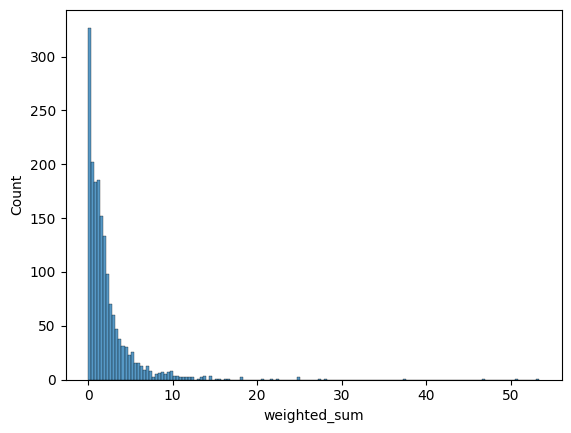

In [14]:
import seaborn as sns


sns.histplot(geneWeightedsumDf.weighted_sum)

## Top genes based on the weighted sum

In [15]:
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]

,gene,weighted_sum
357,essc,53.386270
352,esad,50.876464
479,gltb,46.922011
438,ftsk,37.587255
114,bglg,28.027139
353,esae,27.382075
689,lys2b,25.063095
351,esac,24.748311
325,ebh,22.504625
1029,ptsg,21.585067


## Create gene-type lookup table from amrfinderplus annotations

In [16]:
import os

import pandas as pd

from pathlib import Path


amrfinderDir = Path(os.environ['GENOMICS_DATA_BASE'], 'amrfinder')

amrfinderDfList = []
for amrfinderFile in os.listdir(amrfinderDir):
    amrfinderDf = pd.read_csv(Path(amrfinderDir, amrfinderFile), sep='\t')
    amrfinderDfList.append(amrfinderDf)

allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)
allAmrfinderDf

/tmp/ipykernel_28605/536070399.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allAmrfinderDf = pd.concat(amrfinderDfList, ignore_index=True)


,Protein identifier,Contig id,Start,Stop,Strand,Gene symbol,Sequence name,Scope,Element type,Element subtype,Class,Subclass,Method,Target length,Reference sequence length,% Coverage of reference sequence,% Identity to reference sequence,Alignment length,Accession of closest sequence,Name of closest sequence,HMM id,HMM description
0,NaN,1,83926,85452,-,aur,zinc metalloproteinase aureolysin,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,509,509,100.00,99.41,509,EHO93748.1,zinc metalloproteinase aureolysin,NaN,NaN
1,NaN,1,128415,129464,+,icaC,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,plus,VIRULENCE,VIRULENCE,NaN,NaN,EXACTX,350,350,100.00,100.00,350,AUU58561.1,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,NaN,NaN
2,NaN,1,150950,154498,-,cna,collagen adhesin Cna,plus,VIRULENCE,VIRULENCE,NaN,NaN,BLASTX,1183,1183,100.00,98.31,1183,BAB96477.1,collagen adhesin Cna,NaN,NaN
3,NaN,1,277464,278813,+,tet(38),tetracycline efflux MFS transporter Tet(38),core,AMR,AMR,TETRACYCLINE,TETRACYCLINE,EXACTX,450,450,100.00,100.00,450,WP_001100300.1,tetracycline efflux MFS transporter Tet(38),NaN,NaN
4,NaN,1,505300,506652,+,mepA,multidrug efflux MATE transporter MepA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,451,451,100.00,99.33,451,BAB41547.1,multidrug efflux MATE transporter MepA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57610,NaN,17,83399,84580,-,emrD,multidrug efflux MFS transporter EmrD,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,394,394,100.00,99.24,394,ACN65732.1,multidrug efflux MFS transporter EmrD,NaN,NaN
57611,NaN,2,213498,214724,-,kdeA,multidrug efflux MFS transporter KdeA,plus,AMR,AMR,EFFLUX,EFFLUX,BLASTX,409,410,99.76,99.02,409,ABR76310.1,multidrug efflux MFS transporter KdeA,NaN,NaN
57612,NaN,3,59710,60882,+,oqxA,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,BLASTX,391,391,100.00,99.23,391,WP_002914189.1,multidrug efflux RND transporter periplasmic adaptor subunit OqxA,NaN,NaN
57613,NaN,3,60909,64058,+,oqxB9,multidrug efflux RND transporter permease subunit OqxB9,core,AMR,AMR,PHENICOL/QUINOLONE,PHENICOL/QUINOLONE,ALLELEX,1050,1050,100.00,100.00,1050,WP_012967412.1,multidrug efflux RND transporter permease subunit OqxB9,NaN,NaN


In [17]:
genetypeLookupDf = allAmrfinderDf[['Gene symbol', 'Element type']].drop_duplicates()
genetypeLookupDf['Gene symbol'] = genetypeLookupDf['Gene symbol'].str.lower()
genetypeLookupDf

,Gene symbol,Element type
0,aur,VIRULENCE
1,icac,VIRULENCE
2,cna,VIRULENCE
3,tet(38),AMR
4,mepa,AMR
...,...,...
55837,blapdc-58,AMR
56358,blaact-49,AMR
56951,blandm-4,AMR
56963,aac(6')-ib-cr,AMR


## Read vfdb info

In [18]:
import os
import pandas as pd
from pathlib import Path


vfdbInfoFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'VFDB_info.csv')
vfdbInfoDf = pd.read_csv(vfdbInfoFile)
vfdbInfoDf['Label'] = vfdbInfoDf['Label'].str.lower()
vfdbInfoDf

,Column,ID,Label,Description,Source,Class
0,1,c0393,vat,hemoglobin protease,Escherichia coli O6:K2:H1 CFT073 (UPEC),Autotransporters
1,2,APECO1_O1CoBM73,tsh,Tsh,Escherichia coli O1:K1:H7 (APEC),Autotransporters
2,3,Q673F0_ECOLX,rpea,putative SPATE autotransporter; similar to the SPATE proteins,Escherichia coli plasmid pRAP strain REPEC 83/39,Autotransporters
3,4,ECSF_4010,ecsf_4010,phage protein,Escherichia coli SE15,Autotransporters
4,5,EcSMS35_3921,ecsms35_3921,outer membrane autotransporter,Escherichia coli SMS-3-5 (environmental),Autotransporters
...,...,...,...,...,...,...
249,250,c5077,yddo,ABC transporter ATP-binding protein,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
250,251,c5078,c5078,oligopeptide ABC transporter,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
251,252,c5079,yddq,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes
252,253,c5080,yddr,ABC transporter permease,Escherichia coli O6:K2:H1 CFT073 (UPEC),UPEC specific genes


## Read vf collection

In [19]:
import os
import pandas as pd
from pathlib import Path


vfCollectionDescriptionFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ecoli_VF_collection_description.tsv')
vfCollectionDescriptionDf = pd.read_csv(vfCollectionDescriptionFile, sep='\t')
vfCollectionDescriptionDf['gene'] = vfCollectionDescriptionDf['gene'].str.lower()
vfCollectionDescriptionDf

,gene,locus tag,accession number (protein_id),description,reference,source,class
0,aap,EC042_pAA055,NaN,dispersin,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
1,aata,EC042_pAA008,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
2,aatb,EC042_pAA009,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
3,aatc,EC042_pAA010,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
4,aatd,EC042_pAA011,NaN,dispersin secretion locus ABC transporter,Escherichia coli O44:H18 042 plasmid pAA (EAEC),VFDB R2,Adhesion_invasion
...,...,...,...,...,...,...,...
1064,lngj,NaN,ABU50049,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1065,lngp,NaN,ABU50050,"longus pili, coli surface antigen CS20",Escherichia coli O8:H9 E9034A (ETEC),VFDB R3,Type_4_pilus
1066,etsa,APECO1_O1CoBM197,YP_001481352,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene
1067,etsb,APECO1_O1CoBM198,YP_001481353,ABC transporter,Escherichia coli O1:K1:H7 APEC O1 plasmid pAPEC-O1-ColBM (APEC),manually,Other_virulence_gene


## Read ABRicate

In [20]:
import os
import pandas as pd
from pathlib import Path


abricateFile = Path(os.environ['GENOMICS_DATA_BASE'], 'misc', 'ABRicate.csv')
abricateDf = pd.read_csv(abricateFile)
abricateDf['gene'] = abricateDf['gene'].str.lower()
abricateDf

,gene,type
0,aaa23990,heat-stable enterotoxin
1,aaa24093,heat labile enterotoxin type IIa A
2,aaa24094,heat labile enterotoxin type IIa B
3,apeco1_1753,hypothetical protein
4,apeco1_1761,hypothetical protein
...,...,...
2696,ygeh,transcriptional regulator
2697,yggr,
2698,yghg,
2699,yijp,


## Add gene descriptions to the top genes

In [21]:
geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20].merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
).merge(
    genetypeLookupDf,
    left_on=['gene'],
    right_on=['Gene symbol'],
    how='left'
).rename(
    columns={'Element type': 'AMR Finder Type'}
).merge(
    vfdbInfoDf,
    left_on=['gene'],
    right_on=['Label'],
    how='left'
).rename(
    columns={'Class': 'VFDB Type'}
).merge(
    vfCollectionDescriptionDf,
    on=['gene'],
    how='left'
).rename(
    columns={'class': 'VF Collection Type'}
)[['gene', 'name', 'weighted_sum', 'AMR Finder Type', 'VFDB Type', 'VF Collection Type']].drop_duplicates()

,gene,name,weighted_sum,AMR Finder Type,VFDB Type,VF Collection Type
0,essc,type VII secretion system protein EssC%2C FtsK/SpoIIIE family ATPase,53.386270,NaN,NaN,NaN
1,essc,type VII secretion protein EssC,53.386270,NaN,NaN,NaN
2,esad,type VII secretion system secreted protein%2C a nuclease toxin EsaD,50.876464,NaN,NaN,NaN
3,gltb,glutamate synthase large subunit,46.922011,NaN,NaN,NaN
4,ftsk,DNA segregation ATPase FtsK/SpoIIIE or related protein,37.587255,NaN,NaN,NaN
5,ftsk,DNA translocase FtsK,37.587255,NaN,NaN,NaN
6,bglg,Transcriptional antiterminator,28.027139,NaN,NaN,NaN
7,bglg,BglG family transcription antiterminator,28.027139,NaN,NaN,NaN
8,esae,type VII secretion system chaperone protein,27.382075,NaN,NaN,NaN
9,lys2b,Thioester reductase domain of alpha aminoadipate reductase Lys2 and NRPSs,25.063095,NaN,NaN,NaN


## Save all gene hits

In [22]:
import os
import pandas as pd
from pathlib import Path


outputFile = Path(os.environ['GENOMICS_DATA_BASE'], 'temp', 'saur_top_genes_overlaping_3sd_tokens.csv')

geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False).merge(
    highscoreTokenOverlapsDf[['gene', 'name']].drop_duplicates(),
    on=['gene'],
    how='inner'
)[['gene', 'name', 'weighted_sum']].drop_duplicates().to_csv(outputFile, index=False)

## Create annotations data matrix

In [23]:

signatureAnnotationsDf = highscoreTokenOverlapsDf[highscoreTokenOverlapsDf['gene'].isin(geneWeightedsumDf.sort_values(by=['weighted_sum'], ascending=False)[:20]['gene'])]
signatureAnnotationsDf


,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
51,15955,1,104059,104064,GATGTG,0.027761,CDS,OILJNO_00480,ABC-type multidrug transport system%2C ATPase component,ccma,"ID=OILJNO_00480;Name=ABC-type multidrug transport system%2C ATPase component;locus_tag=OILJNO_00480;product=ABC-type multidrug transport system%2C ATPase component;Dbxref=COG:COG1131,COG:V,RefSeq:WP_000614807.1,SO:0001217,UniParc:UPI00000D76F4,UniRef:UniRef100_A0A0D6HPC7,UniRef:UniRef50_A0A0D6HPC7,UniRef:UniRef90_A0A0D6HPC7;gene=ccmA",AH20I016
52,15967,1,104122,104128,AAAATGG,0.014966,CDS,OILJNO_00480,ABC-type multidrug transport system%2C ATPase component,ccma,"ID=OILJNO_00480;Name=ABC-type multidrug transport system%2C ATPase component;locus_tag=OILJNO_00480;product=ABC-type multidrug transport system%2C ATPase component;Dbxref=COG:COG1131,COG:V,RefSeq:WP_000614807.1,SO:0001217,UniParc:UPI00000D76F4,UniRef:UniRef100_A0A0D6HPC7,UniRef:UniRef50_A0A0D6HPC7,UniRef:UniRef90_A0A0D6HPC7;gene=ccmA",AH20I016
53,16011,1,104373,104377,TTTGT,0.016255,CDS,OILJNO_00480,ABC-type multidrug transport system%2C ATPase component,ccma,"ID=OILJNO_00480;Name=ABC-type multidrug transport system%2C ATPase component;locus_tag=OILJNO_00480;product=ABC-type multidrug transport system%2C ATPase component;Dbxref=COG:COG1131,COG:V,RefSeq:WP_000614807.1,SO:0001217,UniParc:UPI00000D76F4,UniRef:UniRef100_A0A0D6HPC7,UniRef:UniRef50_A0A0D6HPC7,UniRef:UniRef90_A0A0D6HPC7;gene=ccmA",AH20I016
54,16028,1,104463,104469,CCAACAT,0.020258,CDS,OILJNO_00480,ABC-type multidrug transport system%2C ATPase component,ccma,"ID=OILJNO_00480;Name=ABC-type multidrug transport system%2C ATPase component;locus_tag=OILJNO_00480;product=ABC-type multidrug transport system%2C ATPase component;Dbxref=COG:COG1131,COG:V,RefSeq:WP_000614807.1,SO:0001217,UniParc:UPI00000D76F4,UniRef:UniRef100_A0A0D6HPC7,UniRef:UniRef50_A0A0D6HPC7,UniRef:UniRef90_A0A0D6HPC7;gene=ccmA",AH20I016
55,16057,1,104625,104630,AATGAT,0.014629,CDS,OILJNO_00480,ABC-type multidrug transport system%2C ATPase component,ccma,"ID=OILJNO_00480;Name=ABC-type multidrug transport system%2C ATPase component;locus_tag=OILJNO_00480;product=ABC-type multidrug transport system%2C ATPase component;Dbxref=COG:COG1131,COG:V,RefSeq:WP_000614807.1,SO:0001217,UniParc:UPI00000D76F4,UniRef:UniRef100_A0A0D6HPC7,UniRef:UniRef50_A0A0D6HPC7,UniRef:UniRef90_A0A0D6HPC7;gene=ccmA",AH20I016
...,...,...,...,...,...,...,...,...,...,...,...,...
278993,208662,2,541735,541739,CATTG,0.022465,CDS,KKIOAG_06315,Transcriptional antiterminator,bglg,"ID=KKIOAG_06315;Name=Transcriptional antiterminator;locus_tag=KKIOAG_06315;product=Transcriptional antiterminator;Dbxref=COG:COG3711,COG:K,RefSeq:WP_098817967.1,SO:0001217,UniParc:UPI000B187038,UniRef:UniRef100_UPI000B187038,UniRef:UniRef50_A0A2I7YB65,UniRef:UniRef90_A0A2I7YB65;gene=bglG",AH21K020
278994,208681,2,541839,541844,TAACCA,0.013193,CDS,KKIOAG_06315,Transcriptional antiterminator,bglg,"ID=KKIOAG_06315;Name=Transcriptional antiterminator;locus_tag=KKIOAG_06315;product=Transcriptional antiterminator;Dbxref=COG:COG3711,COG:K,RefSeq:WP_098817967.1,SO:0001217,UniParc:UPI000B187038,UniRef:UniRef100_UPI000B187038,UniRef:UniRef50_A0A2I7YB65,UniRef:UniRef90_A0A2I7YB65;gene=bglG",AH21K020
279079,284852,4,130205,130209,AATGA,0.013848,CDS,KKIOAG_08760,putative arabinose efflux permease AraJ%2C MFS family,araj,"ID=KKIOAG_08760;Name=putative arabinose efflux permease AraJ%2C MFS family;locus_tag=KKIOAG_08760;product=putative arabinose efflux permease AraJ%2C MFS family;Dbxref=COG:COG2814,COG:G,RefSeq:WP_000026195.1,SO:0001217,UniParc:UPI00021AE421,UniRef:UniRef100_UPI00021AE421,UniRef:UniRef50_B9E9U7,UniRef:UniRef90_Q9F0Z3;gene=araJ",AH21K020
279080,284938,4,130680,130685,CAATAA,0.013070,CDS,KKIOAG_08760,putative arabinose efflux permease AraJ%2C MFS family,araj,"ID=KKIOAG_08760;Name=putative arabinose efflux permease AraJ%2C MFS family;locus_tag=KKIOAG_08760;product=putative arabinose efflux pe

In [24]:
signatureDataDf = signatureAnnotationsDf[['tube_code', 'gene']].drop_duplicates()
# Get one hot encoding of columns B
one_hot = pd.get_dummies(signatureDataDf['gene'])
# Drop column B as it is now encoded
signatureDataDf = signatureDataDf.drop('gene',axis = 1)
# Join the encoded df
signatureDataDf = signatureDataDf.join(one_hot)
signatureDataDf = signatureDataDf.loc[:, (signatureDataDf != 0).any(axis=0)]
signatureDataDf = signatureDataDf*1
signatureDataDf

,tube_code,acoa,acob,araj,bglg,ccma,ebh,esac,esad,esae,essc,fadb,ftsk,gltb,lys2b,lysr,polc,ptsg,qri1,sbcc,tdh
51,AH20I016,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
102,AH20I016,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
207,AH20I016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
214,AH20I016,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
588,AH20I016,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278549,AH21K067,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
278606,AH21K067,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
278689,AH21K020,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
278938,AH21K020,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Read mapping information

In [25]:
import os

import pandas as pd


demoTrainDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_train.csv', sep='\t')
demoTestDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_test.csv', sep='\t')
demoValidateDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_validate.csv', sep='\t')
demoDf = pd.concat([demoTrainDf, demoTestDf, demoValidateDf], ignore_index=True)
demoDf

,person_id,visit_occurrence_id,TYPE,COUNTRY_OF_BIRTH,SEX,Age_Bin,JOURNEY_ID
0,678487,3312694,Emergency,Australia,Male,"(60, 70]",3312694
1,2094045,9199249,Emergency,Australia,Male,"(20, 30]",9199249
2,2107813,9410987,Emergency,Australia,Male,"(50, 60]",9410987
3,2083212,602890,Inpatient,Australia,Female,"(40, 50]",9039437
4,2083212,9039437,Emergency,Australia,Female,"(40, 50]",9039437
...,...,...,...,...,...,...,...
7194,2603535,16588204,Inpatient,Australia,Male,"(60, 70]",16588204
7195,2603535,16709341,Inpatient,Australia,Male,"(60, 70]",16709341
7196,2603535,16651755,Inpatient,Australia,Male,"(60, 70]",16651755
7197,2098616,16872774,Emergency,Australia,Female,"(80, 90]",16872774


In [26]:
import os

mappingDf = pd.read_csv(os.environ['GENOMICS_DATA_BASE'] + '/patient_tube_id_mapping_full.tsv', sep='\t')
mappingDf

,tube_code,PATIENT_ID,db_ID,pt_age,pt_gender,EPISODE_ID,hospital_admission,hospital_discharge,hospital_in_last_year,genome_species,species_reported,contig_number,length,tube_code_duplicate_or_old,date_of_collection,ID_number,location_additional_02,collected_from_original
0,AH19J072,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Escherichia coli,Escherichia coli,92,5131021,NaN,2019-10-30,19-303-0997,A-7EA;HAEM,Blood
1,AH19J074,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Streptococcus sp. D19,Streptococcus mitis group,84,2022991,NaN,2019-10-30,19-303-1174,A-7EA;HAEM,Blood Peripheral
2,AH19B003,526238.0,567AE,85,Male,640261.0,2019-02-04,2019-02-07,no,Escherichia coli,Escherichia coli,93,4942915,NaN,2019-02-03,19-034-1596,A-4WB;GMC,Blood
3,AH20A024,788941.0,3YBDS,58,Female,13194824.0,2020-01-16,2020-01-19,no,Escherichia coli,Escherichia coli,110,5149157,NaN,2020-01-16,20-016-2112,S-ED;Emergency,Blood Venous
4,AH20L041,1023735.0,2VJ78,42,Male,14210147.0,2020-12-18,2021-01-05,yes,Staphylococcus aureus,Staphylococcus aureus,46,2735216,NaN,2020-12-16,20-351-2856,Emergency Dept;nan,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,ALF22L076,639020.0,3S6HL,84,Male,17219899.0,2022-12-15,2022-12-20,yes,Streptococcus vestibularis,Streptococcus salivarius group,107,1938627,NaN,2022-12-15,22-349-2150,Ward 4WB,Blood Peripheral
3113,ALF22L089,655404.0,6EWBM,67,Female,NaN,NaN,NaN,NaN,Proteus columbae,Proteus vulgaris,152,3972219,NaN,2022-12-17,22-351-1465,Comm/Amb Clinic,Blood
3114,ALF22L138,2572048.0,YM5PJ,61,Male,NaN,NaN,NaN,NaN,Enterobacter roggenkampii,Enterobacter cloacae complex,66,4876179,NaN,2022-12-27,22-361-0202,Ward 7 East,Hick White Lum
3115,ALF23A102,2054964.0,5DYAH,35,Female,17294287.0,2023-01-12,2023-02-01,yes,Streptococcus constellatus,Streptococcus anginosus group,54,1869828,NaN,2023-01-11,23-011-3305,ICU,Blood Venous


In [27]:
mappedJourneyTubeIdsDf = mappingDf[['tube_code', 'PATIENT_ID', 'EPISODE_ID']].drop_duplicates().merge(
    demoDf[['person_id', 'visit_occurrence_id', 'JOURNEY_ID']],
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID', 'visit_occurrence_id']
)[['person_id', 'JOURNEY_ID', 'tube_code']].drop_duplicates()
mappedJourneyTubeIdsDf

,person_id,JOURNEY_ID,tube_code
0,50056,13224842,AH20B011
1,62567,12645629,AH19G065
2,138108,14737781,AH21E052
3,211314,13955099,AH20J009
4,211314,13955099,KPN2214
...,...,...,...
512,2084373,16158768,ALF22C004
513,1058066,16759482,ALF22H089
514,2552781,16966609,ALF22J054
515,2638484,16969999,ALF22K143


## Read mortality labels

In [28]:
import os

import pandas as pd

from pathlib import Path


mortalityTrainDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_1', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_train.csv'), sep='\t')
mortalityTestDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_1', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_test.csv'), sep='\t')
mortalityValidateDf = pd.read_csv(Path(os.environ['EHR_DATA_BASE'], 'blood_pos_cohort_20240614', 'data', 'wb_365_wa_1', 'splits_v1', 'labels', 'mortality', 'mortality_30_day_normal_validate.csv'), sep='\t')
mortalityDf = pd.concat([mortalityTrainDf, mortalityTestDf, mortalityValidateDf], ignore_index=True).drop_duplicates()
mortalityDf

,person_id,JOURNEY_ID,visit_occurrence_id,death_30_day
0,678487,3312694,3312694,0
1,2094045,9199249,9199249,0
2,2107813,9410987,9410987,1
5,2083212,9039437,602890,0
6,2083212,9039437,9039437,0
...,...,...,...,...
30815,2603535,16588204,16588204,0
30820,2603535,16709341,16709341,0
30832,2603535,16651755,16651755,0
30838,2098616,16872774,16872774,0


## Create datamatrix

In [29]:
dataDf = mortalityDf.merge(
    mappedJourneyTubeIdsDf,
    on=['person_id', 'JOURNEY_ID'],
    how='inner'
).drop(
    columns=['visit_occurrence_id']
).drop_duplicates().merge(
    signatureDataDf,
    on=['tube_code'],
    how='inner'
).drop(
    columns=['tube_code']
)
dataDf = dataDf.loc[:, (dataDf != 0).any(axis=0)]
dataDf

,person_id,JOURNEY_ID,death_30_day,acoa,acob,araj,bglg,ccma,ebh,esac,esad,esae,essc,fadb,ftsk,gltb,lys2b,lysr,polc,ptsg,qri1,sbcc,tdh
0,2154700,10220218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2145022,601149,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2145022,601149,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2145022,601149,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2145022,601149,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,1733673,16562760,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
229,1733673,16562760,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
230,2515966,16640224,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
231,2515966,16640224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Calculate correlation

In [30]:
dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False)

,death_30_day,acoa,acob,araj,bglg,ccma,ebh,esac,esad,esae,essc,fadb,ftsk,gltb,lys2b,lysr,polc,ptsg,qri1,sbcc,tdh
death_30_day,1.000000,0.012875,0.012875,0.049464,-0.006630,-0.028774,-0.029126,-0.017407,0.032568,0.032568,-0.079559,0.018369,0.029851,0.076207,0.021466,-0.086160,-0.109279,0.105044,-0.076420,0.068934,-0.048788
ptsg,0.105044,-0.040498,-0.040498,-0.098945,-0.080379,-0.113247,-0.053929,-0.049818,-0.053929,-0.053929,-0.074488,-0.057780,-0.093897,-0.057780,-0.096442,-0.077476,-0.064889,1.000000,-0.045378,-0.045378,-0.061422
gltb,0.076207,-0.024921,-0.024921,-0.060887,-0.049462,-0.069688,-0.033186,-0.030656,-0.033186,-0.033186,-0.045837,-0.035556,-0.057780,1.000000,-0.059347,-0.047676,-0.039930,-0.057780,-0.027924,-0.027924,-0.037796
sbcc,0.068934,-0.019572,-0.019572,-0.047818,-0.038845,-0.054729,-0.026062,-0.024076,-0.026062,-0.026062,-0.035998,-0.027924,-0.045378,-0.027924,-0.046608,-0.037442,-0.031359,-0.045378,-0.021930,1.000000,-0.029683
araj,0.049464,-0.042676,-0.042676,1.000000,-0.084701,-0.119336,-0.056828,-0.052497,-0.056828,-0.056828,-0.078493,-0.060887,-0.098945,-0.060887,-0.101628,-0.081642,-0.068378,-0.098945,-0.047818,-0.047818,-0.064724
esae,0.032568,-0.023260,-0.023260,-0.056828,-0.046165,-0.065042,-0.030973,-0.028613,-0.030973,1.000000,-0.042781,-0.033186,-0.053929,-0.033186,-0.055391,-0.044498,-0.037269,-0.053929,-0.026062,-0.026062,-0.035277
esad,0.032568,-0.023260,-0.023260,-0.056828,-0.046165,-0.065042,-0.030973,-0.028613,1.000000,-0.030973,-0.042781,-0.033186,-0.053929,-0.033186,-0.055391,-0.044498,-0.037269,-0.053929,-0.026062,-0.026062,-0.035277
ftsk,0.029851,-0.040498,-0.040498,-0.098945,-0.080379,-0.113247,-0.053929,-0.049818,-0.053929,-0.053929,-0.074488,-0.057780,1.000000,-0.057780,-0.096442,-0.077476,-0.064889,-0.093897,-0.045378,-0.045378,-0.061422
lys2b,0.021466,-0.041596,-0.041596,-0.101628,-0.082558,-0.116317,-0.055391,-0.051169,-0.055391,-0.055391,-0.076507,-0.059347,-0.096442,-0.059347,1.000000,-0.079576,-0.066648,-0.096442,-0.046608,-0.046608,-0.063087
fadb,0.018369,-0.024921,-0.024921,-0.060887,-0.049462,-0.069688,-0.033186,-0.030656,-0.033186,-0.033186,-0.045837,1.000000,-0.057780,-0.035556,-0.059347,-0.047676,-0.039930,-0.057780,-0.027924,-0.027924,-0.037796


## Plot correlations as a heatmap

<Axes: >

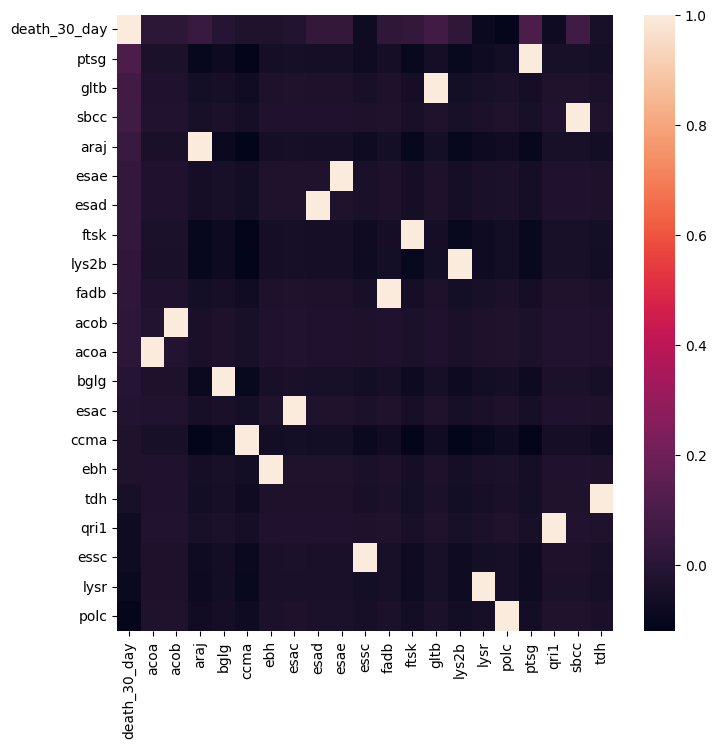

In [31]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr().sort_values('death_30_day', ascending=False))

## Plot correlations as a heatmap (Log scale)

<Axes: >

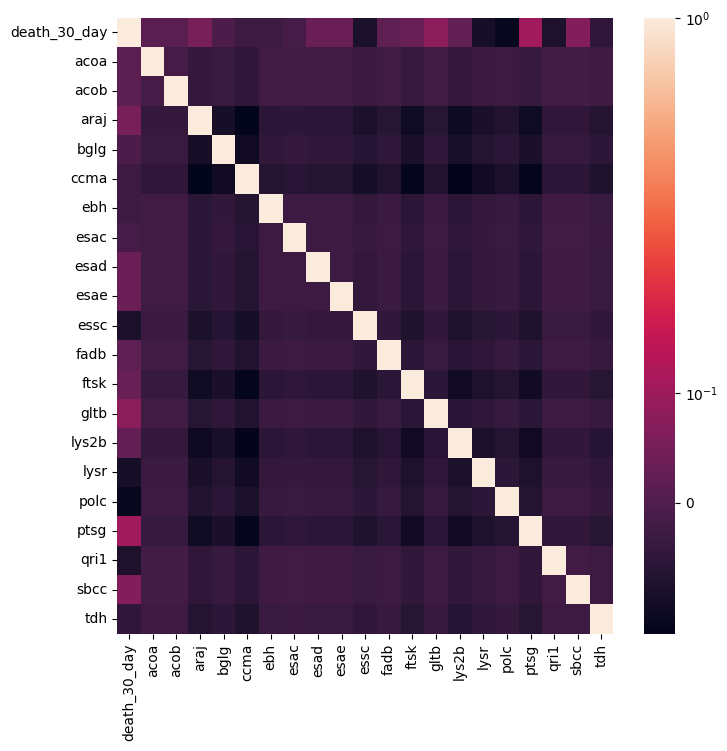

In [32]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.colors import SymLogNorm


f, ax = plt.subplots(1, 1, figsize=(8, 8))

# plot the heatmap
sns.heatmap(dataDf.drop(columns=['person_id', 'JOURNEY_ID']).corr(), norm=SymLogNorm(linthresh=0.3))

## Model using machine learning

In [33]:
X = dataDf.drop(columns=['person_id', 'JOURNEY_ID', 'death_30_day'])
y = dataDf.death_30_day

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.3404255319148936

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lrc = LogisticRegression(random_state=0)
y_pred = lrc.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.8297872340425532

In [36]:
coefficients = lrc.coef_[0]
featureImportanceDf = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
    }).sort_values(by=['Coefficient'])
featureImportanceDf

,Feature,Coefficient
14,lysr,-0.885390
15,polc,-0.829748
17,qri1,-0.326170
9,essc,-0.304965
19,tdh,-0.223135
12,gltb,-0.131106
3,bglg,-0.109850
4,ccma,-0.046682
5,ebh,-0.025876
6,esac,-0.025876


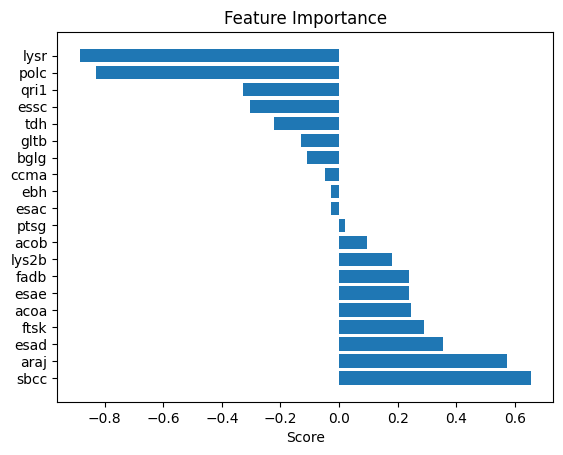

In [37]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.barh(y=featureImportanceDf.Feature, width=featureImportanceDf.Coefficient, align='center')
# ax.set_yticks(y_pos, labels=people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Score')
ax.set_title('Feature Importance')

plt.show()
